# Tutorial 1: Entanglement Forged VQE for the $H_2$ molecule

In this tutorial, we apply Entanglement Forged VQE to compute the energy of a $H_2$ molecule. 

For comparison, you may wish to review how regular VQE is used to solve the same problem [here](https://github.com/Qiskit/qiskit-nature/blob/stable/0.1/docs/tutorials/03_ground_state_solvers.ipynb). 

## Import the relevant modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys

from matplotlib import pyplot as plt
import numpy as np

from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers import (
                                                    GroundStateEigensolver, 
                                                    NumPyMinimumEigensolverFactory)

sys.path.append('../../')
from entanglement_forging import EntanglementForgedGroundStateSolver
from entanglement_forging import EntanglementForgedConfig

## Set up the chemical problem

In [3]:
# Specify Molecule and geometry
molecule = Molecule(geometry=[('H', [0., 0., 0.]),
                              ('H', [0., 0., 0.735])],
                     charge=0, multiplicity=1)

# Calculate second quantized operators
driver = PySCFDriver.from_molecule(molecule = molecule)
problem = ElectronicStructureProblem(driver)
problem.second_q_ops()

# Instantiate our fermion-to-qubit converter
converter = QubitConverter(JordanWignerMapper())

## Compute the classical result for comparison

In [4]:
solver = GroundStateEigensolver(converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False))
result = solver.solve(problem)

print('Classical energy = ', result.total_energies[0])

Classical energy =  -1.1373060357534013


## Prepare the bitstrings and the ansatz

The ansatz for Forged VQE consists of a set of input bitstrings and a parameterized circuit. In the current implementation, the bitstrings and parameterized circuit are the same for the alpha particle subspace and the beta particle subspace. For a discussion on picking the bitstrings and designing the ansatz, refer to the Explanatory Material. 

In [5]:
# The ansatz for forged VQE is represented by a set of bitstrings and a parameterized circuit
ansatz_bitstrings = [[1,0],[0,1]]
ansatz_circuit = TwoLocal(2, [], 'cry', [[0,1],[1,0]], reps=1)

print(ansatz_circuit.draw())

     ┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘


## Prepare the forged ground state solver

In [6]:
backend = Aer.get_backend('statevector_simulator')
config = EntanglementForgedConfig(backend=backend, maxiter = 50, initial_params=[0,0.5*np.pi])
solver = EntanglementForgedGroundStateSolver(converter, ansatz_circuit, ansatz_bitstrings, config)

## Calculate the ground state energy and print the results

In [7]:
calc = EntanglementForgedGroundStateSolver(converter, ansatz_circuit, ansatz_bitstrings, config)
res = calc.solve(problem)

res

Ground state energy (Hartree): -1.1240734567016282
Schmidt values: [-0.99782768  0.06587815]
Optimizer parameters: [6.2832114  1.38526389]

## Plot the optimizer history

Energies (from only one paramset in each iteration):


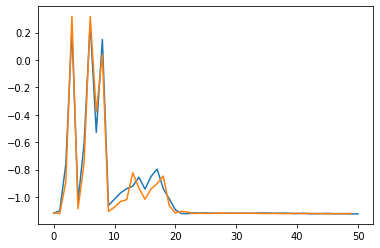

Schmidts (from only one paramset in each iteration):


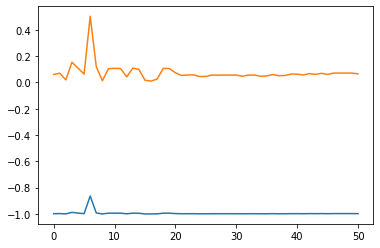

Parameters (from only one paramset in each iteration):


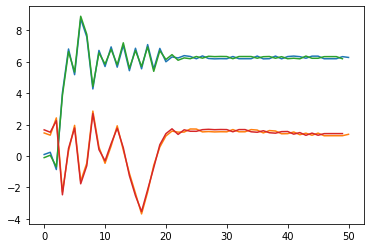

In [8]:
print('Energies (from only one paramset in each iteration):')
plt.plot([e[0] for e in res.get_energies_history()])
plt.plot([e[1] for e in res.get_energies_history()[0:-1]])
plt.show()
print('Schmidts (from only one paramset in each iteration):')
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()
print('Parameters (from only one paramset in each iteration):')
plt.plot([p[0] for p in res.get_parameters_history()])
plt.plot([p[1] for p in res.get_parameters_history()[0:-1]])
plt.show()

In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright